# BBoxTest.py

In [ ]:
# @title 默认标题文本
"""
Significance testing based on black-box models
"""

# Author: Ben Dai <bendai@cuhk.edu.hk>

from tensorflow.keras.models import load_model
import numpy as np
from scipy.stats import norm, mode
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import glorot_uniform
import tensorflow as tf
from sklearn.model_selection import KFold
from scipy.stats import hmean, gmean
import scipy.optimize
import matplotlib.pyplot as plt
import os
from scipy.optimize import brentq
from copy import deepcopy
import time


def comb_p_value(P_value, cp):
    """
    combining p-values
    """
    P_value = np.array(P_value)
    P_value
    cv_num = len(P_value)
    # print(P_value)
    if cv_num > 1:
        P_value = np.array(P_value)
        if cp == 'gmean':
            P_value_cp = np.e*gmean(P_value, 0)
        elif cp == 'median':
            P_value_cp = 2*np.median(P_value, 0)
        elif cp == 'Q1':
            P_value_cp = cv_num/2.*np.partition(P_value, 1)[1]
        elif cp == 'min':
            P_value_cp = cv_num*np.min(P_value, 0)
        elif cp == 'hmean':
            P_value_cp = np.e * np.log(cv_num) * hmean(P_value, 0)
        elif cp == 'hommel':
            const = np.sum(1. / (np.arange(cv_num) + 1.))
            order_const = const*(cv_num/(np.arange(cv_num) + 1.))
            P_value_cp = np.sort(P_value)*order_const
            P_value_cp = np.min(P_value_cp)
        elif cp == 'cauchy':
            t0 = np.mean(np.tan((.5 - P_value)*np.pi))
            P_value_cp = .5 - np.arctan(t0)/np.pi
        else:
            warnings.warn("cp should be {geometric, min, median, Q1, hmean, hommel, cauchy}")
    else:
        P_value_cp = np.mean(P_value, 0)
    P_value_cp = np.minimum(P_value_cp, 1.)
    return P_value_cp


def size_fun(x, N, min_N=2000):
    return x + min_N * np.log(x) / 2 / np.log(min_N/2) - N

class split_test(object):
    """
    Class for one-split/two-split test based on deep neural networks.

    Parameters
    ----------

    inf_feats: list-like | shape = (num of tests, dim of features)
     List of covariates/Features under hypothesis testings, one element corresponding to a hypothesis testing.

    model: {keras-defined neural network}
     A neural network for original full dataset

    model_mask: {keras-defined neural network}
     A neural network for masked dataset by masking/changing the features under hypothesis testing

    change: {'mask', 'perm'}, default='mask'
     The way to change the testing features, ``'mask'`` replaces testing features as zeros, while ``'perm'`` permutes features via instances.

    alpha: float (0,1), default=0.05
     The nominal level of the hypothesis testing

    verbose: {0, 1}, default=0
     If print the testing results, 1 indicates YES, 0 indicates NO.

    eva_metric: {'mse', 'zero-one', 'cross-entropy', or custom metric function}
     The evaluation metric, ``'mse'`` is the l2-loss for regression, ``'zero-one'`` is the zero-one loss for classification, ``'cross-entropy'`` is log-loss for classification. It can also be custom metric function as ``eva_metric(y_true, y_pred)``.

    cp_path: string, default='./splitTest_checkpoints'
     The checkpoints path to save the models

    Methods
    -------
    adaRatio
    dual_feat
    testing
    visual
    """

    def __init__(self, inf_feats, model, model_mask, change='mask', alpha=.05, verbose=0, eva_metric='mse', cp_path='./splitTest_checkpoints'):
        self.inf_feats = inf_feats
        self.model = model
        self.model_mask = model_mask
        self.alpha = alpha
        self.change = change
        self.eva_metric = eva_metric
        self.p_values = []
        self.p_values_comb = []
        self.cp_path = cp_path

    def metric(self, y_true, y_pred):
        """
        Return the loss for `self.eva_metric`

        Parameters
        ----------
        y_true: the ground truth

        y_pred: the predicted label

        """

        if self.eva_metric == 'mse':
            metric_tmp = ((y_true - y_pred)**2).flatten()
        elif self.eva_metric == 'mae':
            metric_tmp = abs(y_true - y_pred).flatten()
        elif self.eva_metric == 'zero-one':
            label_pred = np.argmax(y_pred, 1)
            label_true = np.argmax(y_true, 1)
            metric_tmp = 1. - 1.*(label_true == label_pred)
        elif self.eva_metric == 'cross-entropy':
            label_true = np.argmax(y_true, 1)
            metric_tmp = -np.log(y_pred[range(len(y_pred)),label_true])
        else:
            metric_tmp = self.eva_metric(y_true, y_pred)
        return metric_tmp

    def save_init(self):
        """
        Save the initialization for full and mask network models under class Dnn
        """
        self.model.built = True
        self.model_mask.built = True

        # self.model.save_weights(self.cp_path+'/model_init.h5')
        # self.model_mask.save_weights(self.cp_path+'/model_mask_init.h5')
        self.model.save(self.cp_path+'/model_init')
        self.model_mask.save(self.cp_path+'/model_mask_init')

    def reset_model(self):
        """
        Reset the full and mask network models under class Dnn
        """
        self.model.built = True
        self.model_mask.built = True

        # self.model.load_weights(self.cp_path+'/model_init.h5')
        # self.model_mask.load_weights(self.cp_path+'/model_mask_init.h5')
        self.model = load_model(self.cp_path+'/model_init')
        self.model_mask = load_model(self.cp_path+'/model_mask_init')

    def reload_model(self, path_full, path_mask):
        """
        reload the pre-saved model.
        """
        # path_tmp = self.cp_path+'/model'+'_inf'+str(k)+'_cv'+str(h)+'.h5'
        # mask_path_tmp = self.cp_path+'/model_mask'+'_inf'+str(k)+'_cv'+str(h)+'.h5'
        self.model.save_weights(path_full)
        self.model_mask.save_weights(path_mask)
        self.model.load_weights(path_full)
        self.model_mask.load_weights(path_mask)

    ## can be extent to @abstractmethod
    def dual_feat(self, X, cat_feats=[], k=0):
        """
        Return instances with masked/perm k-th hypothesized features (dual feats).

        Parameters
        ----------
        X: array-like
         Target instances.

        cat_feats: list-like, default = []
         The col-index for categorical features

        k: integer, default = 0
         k-th hypothesized features in inf_feats
        """

        if self.change == 'mask':
            Z = self.mask_cov(X, cat_feats=cat_feats, k=k)
        elif self.change == 'perm':
            Z = self.perm_cov(X, k=k)
        return Z


    def mask_cov(self, X, cat_feats=[], k=0):
        """
        Return instances with masked k-th hypothesized features.

        Parameters
        ----------
        X: array-like
         Target instances.

        cat_feats: list-like, default = []
         The col-index for categorical features; now it's only work for tabular data

        k: integer, default = 0
         k-th hypothesized features in inf_feats
        """
        Z = X.copy()
        n_sample = len(Z)

        if len(self.inf_feats[k]) > 1:
            ## for channels_last image data: shape should be (#samples, img_rows, img_cols, channel)
            if len(cat_feats):
                warnings.warn("cat_feats is ignored. cat_feats only works for tabular data, whereas a image dataset is given.")
            Z[:, self.inf_feats[k][0][:,None], self.inf_feats[k][1], :] = 0.
        else:
            ## this for tabular data
            cat_inf_feats = set(self.inf_feats[k]).intersection(set(cat_feats))
            cont_inf_feats = set(self.inf_feats[k]) - set(cat_inf_feats)
            cat_inf_feats, cont_inf_feats = list(cat_inf_feats), list(cont_inf_feats)

            Z[:,cont_inf_feats] = np.array([np.mean(Z[:,cont_inf_feats], axis=0)]*n_sample)
            if len(cat_inf_feats) > 0:
                Z[:,cat_inf_feats] = np.array([mode(Z[:,cat_inf_feats], axis=0)[0][0]]*n_sample)
        return Z

    def perm_cov(self, X, k=0):
        """
        Return instances with permuted k-th hypothesized features.

        Parameters
        ----------
        X: array-like
         Target instances.

        k: integer, default = 0
         k-th hypothesized features in inf_feats
        """
        Z = X.copy()
        if type(self.inf_feats[k]) is list:
            ## for channels_last image data: shape should be (#samples, img_rows, img_cols, channel)
            Z[:,self.inf_feats[k][0][:,None], self.inf_feats[k][1], :]= np.random.permutation(Z[:,self.inf_feats[k][0][:,None], self.inf_feats[k][1], :])
        else:
            Z[:,self.inf_feats[k]]= np.random.permutation(Z[:,self.inf_feats[k]])
        return Z

    def noise_cov(self, X, k=0):
        """
        Return instances with niosed k-th hypothesized features.

        Parameters
        ----------
        X: array-like
         Target instances.

        k: integer, default = 0
         k-th hypothesized features in inf_feats
        """
        Z = X.copy()
        Z[:,self.inf_feats[k]] = np.random.randn(len(X), len(self.inf_feats[k]))
        return Z

    def adaRatio(self, X, y, k=0, cat_feats=[], fit_params={}, split_params={}):
        """
        Return a data-adaptive splitting ratio and perturbation level.

        Parameters
        ----------
        X: array-like | shape=(n_samples, dim1, dim2, ...)
            Features.

        y: array-like | shape=(n_samples, dim)
            Outcomes.

        k: integer, default = 0
            k-th hypothesized features in inf_feats

        fit_params: dict | shape = dict of fitting parameters
            See keras ``fit``: (https://keras.rstudio.com/reference/fit.html), including ``batch_size``, ``epoch``, ``callbacks``, ``validation_split``, ``validation_data``.

        split_params: {dict of splitting parameters}

            split: {'one-split', 'two-split'}, default='one-split'
                one-split or two-split tests.

            perturb: float, default=None
                Perturb level for the one-split test, if ``perturb = None``, then the perturb level is determined by adaptive tunning.

            num_perm: int, default=100
                Number of permutation for determine the splitting ratio.

            ratio_grid: list of float (0,1), default=[.2, .4, .6, .8]**
                A list of estimation/inference ratios under searching.

            if_reverse: {0,1}, default=0
                ``if_reverse = 0`` indicates the loop of ``ratio_grid`` starts from smallest one to largest one; ``if_reverse = 1`` indicates the loop of ``ratio_grid`` starts from largest one to smallest one.

            perturb_scale: integer, default=5
                The scale of perturb, and the perturbation grid is generated based on 2**range(-perturb_scale, perturb_scale)*var(losses by full model)

            min_inf: int, default=0
                The minimal size for inference sample.

            min_est: int, default=0
                The minimal size for estimation sample.

            ratio_method: {'fuse', 'close'}, default='fuse'
                The adaptive splitting method to determine the optimal estimation/inference ratios.

            cv_num: int, default=1
                The number of cross-validation to shuffle the estimation/inference samples in adaptive ratio splitting. We recommend to set **cv_num** in **adaRatio** as same as **cv_num** in **testing**.

            cp: {'gmean', 'min', 'hmean', 'Q1', 'hommel', 'cauchy'}, default ='hommel'
                A method to combine p-values obtained from cross-validation. see (https://arxiv.org/pdf/1212.4966.pdf) for more detail.

            verbose: {0,1}, default=1
                if print the results the adaptive tuning procedure.

        cp: {'gmean', 'min', 'hmean', 'Q1', 'hommel', 'cauchy'} | default = 'hommel'
            A method to combine p-values obtained from cross-validation. see (https://arxiv.org/pdf/1212.4966.pdf) for more detail.

        verbose: {0,1} | default=1
            If print the adaptive splitting process.

        Returns
        -------
        n_opt: integer
            A reasonable estimation sample size.

        m_opt: integer
            A reasonable inference sample size.

        perturb_opt: float
            A reasonable perturbation level.

        """

        split_params_default = {'split': 'one-split',
                        'perturb': None,
                        'num_perm': 100,
                        'ratio_grid': [.2, .4, .6, .8],
                        'if_reverse': 0,
                        'perturb_scale': 5,
                        'min_inf': 0,
                        'min_est': 0,
                        'ratio_method': 'fuse',
                        'cv_num': 1,
                        'cp': 'hommel',
                        'verbose': 1}

        split_params_default.update(split_params)
        split_params = split_params_default

        perturb=split_params['perturb']
        split=split_params['split']
        perturb_scale=split_params['perturb_scale']
        ratio_grid=split_params['ratio_grid']
        if_reverse=split_params['if_reverse']
        min_inf=split_params['min_inf']
        min_est=split_params['min_est']
        ratio_method=split_params['ratio_method']
        num_perm=split_params['num_perm']
        cv_num= split_params['cv_num']
        cp = split_params['cp']
        verbose= split_params['verbose']

        ratio_grid.sort()
        if if_reverse == 1:
            ratio_grid = list(reversed(ratio_grid))

        candidate, Err1_lst, ratio_lst, P_value_lst = [], [], [], []
        found = 0
        if split == 'two-split':
            for ratio_tmp in ratio_grid:
                ratio_tmp = ratio_tmp/2
                m_tmp = int(len(X)*ratio_tmp)
                n_tmp = len(X) - 2*m_tmp
                if (m_tmp < min_inf) or (n_tmp < min_est):
                    continue

                # split data
                P_value = []
                for h in range(cv_num):
                    self.reset_model()
                    P_value_cv = []
                    ## generate permutated samples
                    X_perm = X.copy()
                    X_perm = self.perm_cov(X_perm, k)
                    ## split sample
                    X_train, X_test, y_train, y_test = train_test_split(X_perm, y, train_size=n_tmp, random_state=1)
                    # training for full model
                    history = self.model.fit(x=X_train, y=y_train, **fit_params)

                    # training for mask model
                    Z_train = self.dual_feat(X_train, cat_feats, k)
                    history_mask = self.model_mask.fit(x=Z_train, y=y_train, **fit_params)
                    Z_test = self.dual_feat(X_test, cat_feats, k)

                    # evaluation for mask model
                    pred_y_mask = self.model_mask.predict(Z_test)
                    for j in range(num_perm):
                        X_test_perm = X_test.copy()
                        X_test_perm = self.perm_cov(X_test_perm, k)
                        pred_y = self.model.predict(X_test_perm)
                        ind_inf, ind_inf_mask = train_test_split(range(len(pred_y)), train_size=m_tmp, random_state=42)
                        metric_tmp = self.metric(y_test[ind_inf], pred_y[ind_inf])
                        metric_mask_tmp = self.metric(y_test[ind_inf_mask], pred_y_mask[ind_inf_mask])
                        p_value_tmp = self.diff_p_value(metric_tmp, metric_mask_tmp)
                        P_value_cv.append(p_value_tmp)
                    P_value.append(P_value_cv)
                P_value = np.array(P_value)
                P_value_cp = np.array([comb_p_value(P_value[:,i], cp=cp) for i in range(num_perm)])
                ## compute the type 1 error
                Err1 = len(P_value_cp[P_value_cp < self.alpha]) / len(P_value_cp)
                Err1_lst.append(Err1)
                # P_value_lst.append(P_value)
                ratio_lst.append(ratio_tmp)

                if verbose==1:
                    print('(AdaRatio) Est. Type 1 error: %.3f; p_value_mean: %.3f, inf sample ratio: %.3f'
                        %(Err1, P_value_cp.mean(), ratio_tmp))
                    # print('(AdaRatio) p_value: %.3f, inference sample ratio: %.3f' %(P_value.mean(), ratio_tmp))

                if Err1 < self.alpha:
                    found = 1
                    if ratio_method == 'fuse':
                        m_opt = m_tmp
                        n_opt = len(X) - 2*m_opt
                        break

            if found==0:
                warnings.warn("No ratio can control the Type 1 error, pls increase the sample size, and the inference sample ratio is set as the min of ratio_grid.")
                Err1_lst, ratio_lst = np.array(Err1_lst), np.array(ratio_lst)
                m_opt = int(ratio_lst[np.argmin(Err1_lst)] * len(X))
                n_opt = len(X) - 2*m_opt

            return n_opt, m_opt

        if split == 'one-split':
            if perturb != None:
                perturb_grid = [perturb]

            for perturb_idx_tmp in range(-perturb_scale, perturb_scale):
                perturb_level_tmp = 2**(perturb_idx_tmp)
                ## stop if current perturb is enough to control the type 1 error
                if found == 1:
                    break
                Err1_lst, ratio_lst, perturb_lst, P_value_lst = [], [], [], []
                for ratio_tmp in ratio_grid:
                    m_tmp = int(len(X)*ratio_tmp)
                    n_tmp = len(X) - m_tmp

                    if (m_tmp < min_inf) or (n_tmp < min_est):
                        continue
                    # split data
                    P_value = []
                    for h in range(cv_num):
                        self.reset_model()
                        P_value_cv = []
                        ## generate permutated samples
                        X_perm = X.copy()
                        X_perm = self.perm_cov(X_perm, k)
                        # split samples
                        X_train, X_test, y_train, y_test = train_test_split(X_perm, y, train_size=n_tmp, random_state=h)
                        # training for full model
                        history = self.model.fit(x=X_train, y=y_train, **fit_params)

                        # training for mask model
                        Z_train = self.dual_feat(X_train, cat_feats, k)
                        history_mask = self.model_mask.fit(x=Z_train, y=y_train, **fit_params)

                        ## evaluation for the mask model
                        Z_test = self.dual_feat(X_test, cat_feats, k)
                        pred_y_mask = self.model_mask.predict(Z_test)
                        metric_mask_tmp = self.metric(y_test, pred_y_mask)

                        # evaluation
                        for j in range(num_perm):
                            X_test_perm = X_test.copy()
                            X_test_perm = self.perm_cov(X_test_perm, k)
                            ## compute the metric based on full model
                            pred_y = self.model.predict(X_test_perm)
                            metric_tmp = self.metric(y_test, pred_y)
                            ## compute the p-value based on the diff metrics
                            p_value_tmp = self.diff_p_value(metric_tmp, metric_mask_tmp,
                                                    perturb_level=perturb_level_tmp)
                            P_value_cv.append(p_value_tmp)
                        P_value.append(P_value_cv)

                    P_value = np.array(P_value)

                    P_value_cp = np.array([comb_p_value(P_value[:,i], cp=cp) for i in range(num_perm)])
                    Err1 = len(P_value_cp[P_value_cp<=self.alpha])/len(P_value_cp)
                    Err1_lst.append(Err1)

                    if verbose==1:
                        print('(AdaRatio) Est. Type 1 err: %.3f; p_value_mean: %.3f, inf sample ratio: %.3f, perturb_level: %s'
                            %(Err1, P_value_cp.mean(), ratio_tmp, perturb_level_tmp))

                    P_value_lst.append(P_value_cp)
                    ratio_lst.append(ratio_tmp)
                    perturb_lst.append(perturb_idx_tmp)

                    if Err1 < self.alpha:
                        found = 1
                        m_opt = m_tmp
                        n_opt = len(X) - m_opt
                        perturb_idx_opt = perturb_idx_tmp
                        break
            if found==0:
                warnings.warn("No ratio and perturb_level can control the Type 1 error," \
                    "pls increase the perturb_level and sample size, and inference sample ratio is set as the one minimize the permutation Type 1 Error.")
                Err1_lst, ratio_lst = np.array(Err1_lst), np.array(ratio_lst)
                m_opt = int(ratio_lst[np.argmin(Err1_lst)] * len(X))
                n_opt = len(X) - m_opt
                perturb_idx_opt = perturb_lst[np.argmin(Err1_lst)]

            return n_opt, m_opt, perturb_idx_opt


    def diff_p_value(self, metric_full, metric_mask, perturb_level=0.):
        """
        Return p-value for diff btw `metric_full` and `metric_mask` for the one-/two-split test.

        Parameters
        ----------
        metric_full: {array-like} of shape (n_samples)
            metric for samples based on full model

        metric_mask: {array-like} of shape (n_samples)
            metric for samples based on mask model

        Returns
        -------

        P_value: array of float [0, 1]
            The p_values for target one-/two-split test.
        """
        perturb_base = metric_full.std()
        diff_tmp = metric_full - metric_mask + perturb_level * perturb_base * np.random.randn(len(metric_full))
        Lambda_tmp = np.sqrt(len(diff_tmp)) * ( diff_tmp.std() )**(-1)*( diff_tmp.mean() )
        p_value_tmp = norm.cdf(Lambda_tmp)
        return p_value_tmp

    def testing(self, X, y, fit_params, split_params={}, cat_feats=[], cv_num=5, cp='hommel', inf_ratio=None):
        """
        Return p-values for hypothesis testing for inf_feats in class split_test.

        Parameters
        ----------

        X: {array-like} of shape (n_samples, dim_features)
            Instances matrix/tensor, where n_samples in the number of samples and dim_features is the dimension of the features.
             If X is vectorized feature, ``shape`` should be ``(#Samples, dim of feaures)``
             If X is image/matrix data, ``shape`` should be ``(#samples, img_rows, img_cols, channel)``, that is, *X must channel_last image data*.

        y: {array-like} of shape (n_samples,)
             Output vector/matrix relative to X.

        cat_feats: list, default = []
            The col-index for categorical features; **now it's only work for tabular data**

        fit_params: {dict of fitting parameters}
            See keras ``fit``: (https://keras.rstudio.com/reference/fit.html), including ``batch_size``, ``epoch``, ``callbacks``, ``validation_split``, ``validation_data``, and so on.

        split_params: {dict of splitting parameters}

            split: {'one-split', 'two-split'}, default='one-split'
                one-split or two-split test statistic.

            perturb: float, default=None
                Perturb level for the one-split test, if ``perturb = None``, then the perturb level is determined by adaptive tunning.

            num_perm: int, default=100
                Number of permutation for determine the splitting ratio.

            ratio_grid: list of float (0,1), default=[.2, .4, .6, .8]**
                A list of estimation/inference ratios under searching.

            if_reverse: {0,1}, default=0
                ``if_reverse = 0`` indicates the loop of ``ratio_grid`` starts from smallest one to largest one; ``if_reverse = 1`` indicates the loop of ``ratio_grid`` starts from largest one to smallest one.

            perturb_scale: integer, default=5
                The scale of perturb, and the perturbation grid is generated based on 2**range(-perturb_scale, perturb_scale)*var(losses by full model)

            min_inf: int, default=0
                The minimal size for inference sample.

            min_est: int, default=0
                The minimal size for estimation sample.

            ratio_method: {'fuse', 'close'}, default='fuse'
                The adaptive splitting method to determine the optimal estimation/inference ratios.

            cv_num: int, default=*cv_num*
                The number of cross-validation to shuffle the estimation/inference samples in adaptive ratio splitting.

            cp: {'gmean', 'min', 'hmean', 'Q1', 'hommel', 'cauchy'}, default = *cp*
                A method to combine p-values obtained from cross-validation. see (https://arxiv.org/pdf/1212.4966.pdf) for more detail.

            verbose: {0,1}, default=1
                if print the results the adaptive tuning procedure.

        cv_num: int, default=5
            The number of cross-validation to shuffle the estimation/inference samples in testing.

        cp: {'gmean', 'min', 'hmean', 'Q1', 'hommel', 'cauchy'}, default ='hommel'
            A method to combine p-values obtained from cross-validation.

        inf_ratio: float, default=None**
            A pre-specific inference sample ratio, if ``est_size=None``, then it is determined by adaptive splitting method ``metric``.

        Returns
        -------

        P_value: array of float [0, 1]
            The p_values for target hypothesis testings.

        """
        split_params_default = {'split': 'one-split',
                                'perturb': None,
                                'num_perm': 100,
                                'perturb_scale': 5,
                                'ratio_grid': [.2, .4, .6, .8],
                                'if_reverse': 0,
                                'min_inf': 0,
                                'min_est': 0,
                                'ratio_method': 'fuse',
                                'cv_num': cv_num,
                                'cp': cp,
                                'verbose': 1}

        split_params_default.update(split_params)
        split_params = split_params_default

        ## create checkpoints path
        if not os.path.exists(self.cp_path):
            os.mkdir(self.cp_path)
        ## save initial weights
        self.save_init()
        init_lr_full = deepcopy(self.model.optimizer.lr.numpy())
        init_lr_mask = deepcopy(self.model.optimizer.lr.numpy())

        P_value = []

        for k in range(len(self.inf_feats)):
            ## initialize the models and learning rates
            self.reset_model()
            self.model.optimizer.lr.assign(init_lr_full)
            self.model_mask.optimizer.lr.assign(init_lr_mask)

            ## (one-split) determine the splitting ratio for est and inf samples
            if split_params['split'] == 'one-split':
                if ((inf_ratio == None) or (split_params['perturb'] == None)):
                    if split_params['ratio_method'] == 'fuse':
                        n, m, perturb_idx = self.adaRatio(X, y, k, cat_feats=cat_feats,
                                                    fit_params=fit_params, split_params=split_params)
                        perturb_level = 2**perturb_idx
                        print('%d-th inference; Adaptive data splitting: n: %d; m: %d; perturb: %s'
                            %(k, n, m, perturb_level))

                    elif split_params['ratio_method'] == 'log-ratio':
                        root, info = brentq(size_fun, 3., len(X), args=(len(X), 2000.), full_output=True)
                        inf_ratio = 1 - root / len(X)
                        if split_params['perturb'] == None:
                            split_params['ratio_grid'] = [inf_ratio]
                            n, m, perturb_idx = self.adaRatio(X, y, k, cat_feats=cat_feats,
                                                    fit_params=fit_params, split_params=split_params)
                            perturb_level = 2**perturb_idx
                        else:
                            perturb_idx = split_params['perturb']
                            perturb_level = 2**perturb_idx
                            m, n = int(inf_ratio * len(X)), len(X) - int(inf_ratio * len(X))
                        print('%d-th inference; log ratio data splitting: n: %d; m: %d; perturb: %s'
                            %(k, n, m, perturb_level))
                    else:
                        raise Exception("inf ratio method must be 'fuse' or 'log-ratio' if inf_ratio is not given!")
                else:
                    m, n = int(inf_ratio * len(X)), len(X) - int(inf_ratio * len(X))
                    perturb_idx = split_params['perturb']
                    perturb_level = 2**perturb_idx
                    print('%d-th inference; fix data splitting: n: %d; m: %d' %(k, n, m))

            ## (two-split) determine the splitting ratio for est and inf samples
            elif split_params['split'] == 'two-split':
                perturb_level = 0.
                if inf_ratio == None:
                    if split_params['ratio_method'] == 'fuse':
                        n, m = self.adaRatio(X, y, k, cat_feats=cat_feats,
                                            fit_params=fit_params, split_params=split_params)
                        print('%d-th inference; Adaptive data splitting: n: %d; m: %d' %(k, n, m))
                    elif split_params['ratio_method'] == 'log-ratio':
                        root, info = brentq(size_fun, 3., len(X), args=(len(X), 2000.), full_output=True)
                        inf_ratio = 1 - root / len(X)
                        m, n = int(inf_ratio * len(X)/2)*2, len(X) - int(inf_ratio * len(X)/2)*2
                        print('%d-th inference; log-ratio data splitting: n: %d; m: %d' %(k, n, m))
                    else:
                        raise Exception("inf ratio method must be 'fuse' or 'log-ratio' if inf_ratio is not given!")
                else:
                    m, n = int(inf_ratio * len(X)/2)*2, len(X) - int(inf_ratio * len(X)/2)*2
            else:
                raise Exception("split method must be 'one-split' or 'two-split'!")

            ## testing
            P_value_cv = []
            for h in range(cv_num):
                X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n, random_state=h)
                if split_params['split'] == 'two-split':
                    X_inf, X_inf_mask, y_inf, y_inf_mask = train_test_split(X_test, y_test, train_size=.5, random_state=42)
                if split_params['split'] == 'one-split':
                    X_inf, X_inf_mask, y_inf, y_inf_mask = X_test.copy(), X_test.copy(), y_test.copy(), y_test.copy()

                self.reset_model()
                self.model.optimizer.lr.assign(init_lr_full)
                self.model_mask.optimizer.lr.assign(init_lr_mask)

                ## fit, predict, and inference in full model
                history = self.model.fit(X_train, y_train, **fit_params)
                pred_y = self.model.predict(X_inf)
                metric_full = self.metric(y_inf, pred_y)

                # fit, predict, and inference in mask model
                Z_train = self.dual_feat(X_train, cat_feats, k)
                history_mask = self.model_mask.fit(Z_train, y_train, **fit_params)
                Z_inf = self.dual_feat(X_inf_mask, cat_feats, k)
                pred_y_mask = self.model_mask.predict(Z_inf)
                metric_mask = self.metric(y_inf_mask, pred_y_mask)

                ## compute p-value
                p_value_tmp = self.diff_p_value(metric_full, metric_mask, perturb_level)
                print('cv: %d; p_value: %.5f; metric: %.5f(%.5f); metric_mask: %.5f(%.5f)'
                    %(h, p_value_tmp,
                        metric_full.mean(), metric_full.std(),
                        metric_mask.mean(), metric_mask.std()))

                P_value_cv.append(p_value_tmp)

            self.p_values_comb.append(P_value_cv)

            P_value_cv = np.array(P_value_cv)
            p_value_mean = comb_p_value(P_value_cv, cp=cp)

            if p_value_mean < self.alpha:
                print('%d-th inf: reject H0 with p_value: %.3f' %(k, p_value_mean))
            else:
                print('%d-th inf: accept H0 with p_value: %.3f' %(k, p_value_mean))

            P_value.append(p_value_mean)
        # return P_value, fit_err, P_value_cv
        self.p_values = P_value
        return P_value

    def visual(self, X, y, plt_params={'cmap': 'RdBu', 'alpha':0.6}, plt_mask_params={'cmap': 'RdBu', 'alpha':0.6}):
        """
        Visualization for the inference results based on one illustrative example

        Parameters
        ----------
        X: array-like
         demo instances.

        y: array-like
         demo labels

        plt_params: dict
         dictory of parameters for the imshow for original image see: (https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.imshow.html)

        plt_mask_params: dict
         dictory of parameters for the imshow for mask see: (https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.imshow.html)

        """
        if len(X.shape) == 2:
            print('sorry, visual function only work for image data.')
        else:
            num_class = y.shape[1]
            demo_ind = np.array([np.where(y[:,k]==1)[0][0] for k in range(num_class)])
            X_demo = X[demo_ind]

            cols, rows = len(self.inf_feats), num_class
            fig = plt.figure(constrained_layout=False)
            spec = fig.add_gridspec(ncols=cols, nrows=rows)
            for row in range(rows):
                for col in range(cols):
                    X_mask_tmp = np.nan*np.ones(X_demo.shape)
                    X_mask_tmp = self.mask_cov(X_mask_tmp, cat_feats, k=col)[0]
                    ax = fig.add_subplot(spec[row, col])
                    im1 = ax.imshow(X_demo[row], vmin=0, vmax=1, **plt_params)
                    ax.axis('off')
                    im2 = ax.imshow(X_mask_tmp, vmin=0, vmax=1, **plt_mask_params)
                    ax.axis('off')
                    if row == 0:
                        ax.set_title('p_values: %.3f' %self.p_values[col])
            plt.subplots_adjust(top = 0.95, bottom=0.05, hspace=0.03, wspace=0.03, right=0.95)
            plt.show()


class perm_test(object):
    """Class for holdout permutation test (HPT) based on deep neural networks.

    Parameters
    ----------

    inf_feats : list-like of shape (num of tests, dim of features)
     List of covariates/Features under hypothesis testings, one element corresponding to a hypothesis testing.

    model : {keras-defined neural network}
     A neural network for original full dataset

    alpha: float (0,1), default=0.05
     The nominal level of the hypothesis testing

    verbose: {0, 1}, default=0
     If print the testing results, 1 indicates YES, 0 indicates NO.

    eva_metric: {'mse', 'zero-one', 'cross-entropy', or custom metric function}
     The evaluation metric, ``'mse'`` is the l2-loss for regression, ``'zero-one'`` is the zero-one loss for classification, ``'cross-entropy'`` is log-loss for classification. It can also be custom metric function as ``eva_metric(y_true, y_pred)``.

    Methods
    -------
    testing
    """

    def __init__(self, inf_feats, model, model_perm, alpha=.05, num_folds=5, num_perm=100, verbose=0, eva_metric='mse'):
        self.inf_feats = inf_feats
        self.model = model
        self.model_perm = model_perm
        self.alpha = alpha
        self.num_perm = num_perm
        self.num_folds = num_folds
        self.eva_metric = eva_metric

    def metric(self, y_true, y_pred):
        if self.eva_metric == 'mse':
            metric_tmp = ((y_true - y_pred)**2).flatten()
        elif self.eva_metric == 'mae':
            metric_tmp = abs(y_true - y_pred).flatten()
        elif self.eva_metric == 'zero-one':
            label_pred = np.argmax(y_pred, 1)
            label_true = np.argmax(y_true, 1)
            metric_tmp = 1. - 1.*(label_true == label_pred)
        elif self.eva_metric == 'cross-entropy':
            label_true = np.argmax(y_true, 1)
            metric_tmp = np.log(y_pred[range(len(y_pred)),label_true])
        else:
            metric_tmp = self.eva_metric(y_true, y_pred)
        return metric_tmp

    def reset_model(self):
        if int(tf.__version__[0]) == 2:
            # for layer in self.model.layers:
            #   if isinstance(layer, tf.keras.Model):
            #       reset_weights(layer)
            #       continue
            #   for k, initializer in layer.__dict__.items():
            #       if "initializer" not in k:
            #           continue
            #           # find the corresponding variable
            #       var = getattr(layer, k.replace("_initializer", ""))
            #       var.assign(initializer(var.shape, var.dtype))

            for layer in self.model.layers:
                if isinstance(layer, tf.keras.Model): #if you're using a model as a layer
                    reset_weights(layer) #apply function recursively
                    continue

                #where are the initializers?
                if hasattr(layer, 'cell'):
                    init_container = layer.cell
                else:
                    init_container = layer

                for key, initializer in init_container.__dict__.items():
                    if "initializer" not in key: #is this item an initializer?
                      continue #if no, skip it

                    # find the corresponding variable, like the kernel or the bias
                    if key == 'recurrent_initializer': #special case check
                        var = getattr(init_container, 'recurrent_kernel')
                    else:
                        var = getattr(init_container, key.replace("_initializer", ""))

                    if var is None:
                        continue
                    else:
                        var.assign(initializer(var.shape, var.dtype))

        if int(tf.__version__[0]) == 1:
            session = K.get_session()
            for layer in self.model.layers:
                if hasattr(layer, 'kernel_initializer'):
                    layer.kernel.initializer.run(session=session)
                if hasattr(layer, 'bias_initializer'):
                    layer.bias.initializer.run(session=session)
            for layer in self.model_perm.layers:
                if hasattr(layer, 'kernel_initializer'):
                    layer.kernel.initializer.run(session=session)
                if hasattr(layer, 'bias_initializer'):
                    layer.bias.initializer.run(session=session)

    ## can be extent to @abstractmethod
    def mask_cov(self, X, k=0):
        Z = X.copy()
        if type(self.inf_feats[k]) is list:
            Z[:,self.inf_feats[k][0][:,None], self.inf_feats[k][1], 0] = 0.
        else:
            Z[:,self.inf_feats[k]]= 0.
        return Z

    def perm_cov(self, X, k=0):
        Z = X.copy()
        if type(self.inf_feats[k]) is list:
            Z[:,self.inf_feats[k][0][:,None], self.inf_feats[k][1], 0]= np.random.permutation(Z[:,self.inf_feats[k][0][:,None], self.inf_feats[k][1], 0])
        else:
            Z[:,self.inf_feats[k]]= np.random.permutation(Z[:,self.inf_feats[k]])
        return Z

    def noise_cov(self, X, k=0):
        Z = X.copy()
        Z[:,self.inf_feats[k]] = np.random.randn(len(X), len(self.inf_feats[k]))
        return Z

    def testing(self, X, y, fit_params={}):
        """
        Return p-values for hypothesis testing for inf_feats in class perm_test.

        Parameters
        ----------

        X : array-like | shape = (n_samples, dim_features)
            Instances matrix/tensor, where n_samples in the number of samples and dim_features is the dimension of the features.
             If X is vectorized feature, ``shape`` should be ``(#Samples, dim of feaures)``
             If X is image/matrix data, ``shape`` should be ``(#samples, img_rows, img_cols, channel)``, that is, *X must channel_last image data*.

        y: {array-like} of shape (n_samples,)
             Output vector/matrix relative to X.

        fit_params: {dict of fitting parameters}
            See keras ``fit``: (https://keras.rstudio.com/reference/fit.html), including ``batch_size``, ``epoch``, ``callbacks``, ``validation_split``, ``validation_data``, and so on.

        cv_num: int, default=5
            The number of cross-validation to shuffle the estimation/inference samples in testing.

        cp: {'gmean', 'min', 'hmean', 'Q1', 'hommel', 'cauchy'}, default ='hommel'
            A method to combine p-values obtained from cross-validation.

        inf_ratio: float, default=None
            A pre-specific inference sample ratio, if ``est_size=None``, then it is determined by adaptive splitting method ``metric``.

        Returns
        -------

        P_value: array of float [0, 1]
            The p_values for target hypothesis testings.

        """
        P_value = []
        for k in range(len(self.inf_feats)):
            kfold = KFold(n_splits=self.num_folds, shuffle=True)
            self.reset_model()
            print('%d-th permutation inference' %k)
            ## prediction and inference in full model
            score_cv = []
            for train, test in kfold.split(X, y):
                self.reset_model()
                history = self.model.fit(X[train], y[train], **fit_params)
                pred_y = self.model.predict(X[test])
                metric_full = self.metric(y[test], pred_y)
                score_cv.append(metric_full.mean())
            score = np.mean(score_cv)
            # prediction and inference in mask model
            score_perm = []
            for l in range(self.num_perm):
                score_perm_cv = []
                Z = self.perm_cov(X, k)
                for train_perm, test_perm in kfold.split(Z, y):
                    self.reset_model()
                    history_perm = self.model_perm.fit(Z[train_perm], y[train_perm], **fit_params)
                    pred_y_perm = self.model_perm.predict(Z[test_perm])
                    metric_perm = self.metric(y[test_perm], pred_y_perm)
                    score_perm_cv.append(metric_perm.mean())
                score_perm.append(np.mean(score_perm_cv))
            score_perm = np.array(score_perm)
            ## compute p-value
            print("perf score: %.3f, perf permutation score: %.3f(%.3f)" %(score, score_perm.mean(), score_perm.std()))
            p_value_tmp = (np.sum(score_perm <= score) + 1.0) / (self.num_perm + 1)

            if p_value_tmp < self.alpha:
                print('reject H0 with p_value: %.3f' %p_value_tmp)
            else:
                print('accept H0 with p_value: %.3f' %p_value_tmp)

            P_value.append(p_value_tmp)
        return P_value, metric_full.mean()



class Hperm_test(object):
    """Class for holdout permutation test (HPT) based on deep neural networks.

    Parameters
    ----------

    inf_feats : list-like of shape (num of tests, dim of features)
     List of covariates/Features under hypothesis testings, one element corresponding to a hypothesis testing.

    model : {keras-defined neural network}
     A neural network for original full dataset

    alpha: float (0,1), default=0.05
     The nominal level of the hypothesis testing

    verbose: {0, 1}, default=0
     If print the testing results, 1 indicates YES, 0 indicates NO.

    eva_metric: {'mse', 'zero-one', 'cross-entropy', or custom metric function}
     The evaluation metric, ``'mse'`` is the l2-loss for regression, ``'zero-one'`` is the zero-one loss for classification, ``'cross-entropy'`` is log-loss for classification. It can also be custom metric function as ``eva_metric(y_true, y_pred)``.

    cp_path: {string}, default='./HPT_checkpoints'
     The checkpoints path to save the models

    Methods
    -------
    testing
    """

    def __init__(self, inf_feats, model, alpha=.05, num_perm=1000, verbose=0, eva_metric='mse', cp_path = './HPT_checkpoints'):
        self.inf_feats = inf_feats
        self.model = model
        self.alpha = alpha
        self.num_perm = num_perm
        self.eva_metric = eva_metric
        self.cp_path = cp_path

    def metric(self, y_true, y_pred):
        if self.eva_metric == 'mse':
            metric_tmp = ((y_true - y_pred)**2).flatten()
        elif self.eva_metric == 'mae':
            metric_tmp = abs(y_true - y_pred).flatten()
        elif self.eva_metric == 'zero-one':
            label_pred = np.argmax(y_pred, 1)
            label_true = np.argmax(y_true, 1)
            metric_tmp = 1. - 1.*(label_true == label_pred)
        elif self.eva_metric == 'cross-entropy':
            label_true = np.argmax(y_true, 1)
            metric_tmp = np.log(y_pred[range(len(y_pred)),label_true])
        else:
            metric_tmp = self.eva_metric(y_true, y_pred)
        return metric_tmp

    def save_init(self):
        """
        Save the initialization for the network model under class HPT
        """
        self.model.save_weights(self.cp_path+'/model_init.h5')
        # self.model_mask.save_weights(self.cp_path+'/model_mask_init.h5')

    def reset_model(self):
        """
        Reset the full and mask network models under class HPT
        """
        self.model.load_weights(self.cp_path+'/model_init.h5')
        # self.model_mask.load_weights(self.cp_path+'/model_mask_init.h5')

    # def reset_model(self):
    #   if int(tf.__version__[0]) == 2:
    #       # for layer in self.model.layers:
    #       #   if isinstance(layer, tf.keras.Model):
    #       #       reset_weights(layer)
    #       #       continue
    #       #   for k, initializer in layer.__dict__.items():
    #       #       if "initializer" not in k:
    #       #           continue
    #       #           # find the corresponding variable
    #       #       var = getattr(layer, k.replace("_initializer", ""))
    #       #       var.assign(initializer(var.shape, var.dtype))
    #
    #       for layer in self.model.layers:
    #           if isinstance(layer, tf.keras.Model): #if you're using a model as a layer
    #               reset_weights(layer) #apply function recursively
    #               continue
    #
    #           #where are the initializers?
    #           if hasattr(layer, 'cell'):
    #               init_container = layer.cell
    #           else:
    #               init_container = layer
    #
    #           for key, initializer in init_container.__dict__.items():
    #               if "initializer" not in key: #is this item an initializer?
    #                 continue #if no, skip it
    #
    #               # find the corresponding variable, like the kernel or the bias
    #               if key == 'recurrent_initializer': #special case check
    #                   var = getattr(init_container, 'recurrent_kernel')
    #               else:
    #                   var = getattr(init_container, key.replace("_initializer", ""))
    #
    #               if var is None:
    #                   continue
    #               else:
    #                   var.assign(initializer(var.shape, var.dtype))
    #
    #   if int(tf.__version__[0]) == 1:
    #       session = K.get_session()
    #       for layer in self.model.layers:
    #           if hasattr(layer, 'kernel_initializer'):
    #               layer.kernel.initializer.run(session=session)
    #           if hasattr(layer, 'bias_initializer'):
    #               layer.bias.initializer.run(session=session)
    #       for layer in self.model_perm.layers:
    #           if hasattr(layer, 'kernel_initializer'):
    #               layer.kernel.initializer.run(session=session)
    #           if hasattr(layer, 'bias_initializer'):
    #               layer.bias.initializer.run(session=session)

    ## can be extent to @abstractmethod
    # def mask_cov(self, X, k=0):
    #   """
    #   Return instances with masked k-th hypothesized features.
    #
    #   Parameters
    #   ----------
    #   X : array-like
    #    Target instances.
    #
    #   k : integer, default = 0
    #    k-th hypothesized features in inf_feats
    #   """
    #   Z = X.copy()
    #   if type(self.inf_feats[k]) is list:
    #       Z[:,self.inf_feats[k][0][:,None], self.inf_feats[k][1], 0] = 0.
    #   else:
    #       Z[:,self.inf_feats[k]]= 0.
    #   return Z

    def perm_cov(self, X, k=0):
        """
        Return instances with permuted k-th hypothesized features.

        Parameters
        ----------
        X : array-like
         Target instances.

        k : integer, default = 0
         k-th hypothesized features in inf_feats
        """
        Z = X.copy()
        if type(self.inf_feats[k]) is list:
            ## for channels_last image data: shape should be (#samples, img_rows, img_cols, channel)
            Z[:,self.inf_feats[k][0][:,None], self.inf_feats[k][1], :] = np.random.permutation(Z[:,self.inf_feats[k][0][:,None], self.inf_feats[k][1], :])
        else:
            Z[:,self.inf_feats[k]]= np.random.permutation(Z[:,self.inf_feats[k]])
        return Z

    def noise_cov(self, X, k=0):
        Z = X.copy()
        Z[:,self.inf_feats[k]] = np.random.randn(len(X), len(self.inf_feats[k]))
        return Z

    def testing(self, X, y, fit_params, cv_num=5, cp='hommel', inf_ratio=.2):
        """
        Return p-values for hypothesis testing for inf_feats in class HpermT.

        Parameters
        ----------

        X : array-like | shape = (n_samples, dim_features)
            Instances matrix/tensor, where n_samples in the number of samples and dim_features is the dimension of the features.
             If X is vectorized feature, ``shape`` should be ``(#Samples, dim of feaures)``
             If X is image/matrix data, ``shape`` should be ``(#samples, img_rows, img_cols, channel)``, that is, *X must channel_last image data*.

        y: {array-like} of shape (n_samples,)
             Output vector/matrix relative to X.

        fit_params: {dict of fitting parameters}
            See keras ``fit``: (https://keras.rstudio.com/reference/fit.html), including ``batch_size``, ``epoch``, ``callbacks``, ``validation_split``, ``validation_data``, and so on.

        cv_num: int, default=5
            The number of cross-validation to shuffle the estimation/inference samples in testing.

        cp: {'gmean', 'min', 'hmean', 'Q1', 'hommel', 'cauchy'}, default ='hommel'
            A method to combine p-values obtained from cross-validation.

        inf_ratio: float, default=None
            A pre-specific inference sample ratio, if ``est_size=None``, then it is determined by adaptive splitting method ``metric``.

        Returns
        -------

        P_value: array of float [0, 1]
            The p_values for target hypothesis testings.

        """

        ## create checkpoints path
        if not os.path.exists(self.cp_path):
            os.mkdir(self.cp_path)
        ## save initial weights
        self.save_init()

        P_value = []
        for k in range(len(self.inf_feats)):
            self.reset_model()
            m, n = int(inf_ratio * len(X)), len(X) - int(inf_ratio * len(X))
            P_value_cv = []
            score_cv, score_perm_cv = [], []
            for h in range(cv_num):
                X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n, random_state=h)
                ## prediction and inference in full model
                self.reset_model()
                history = self.model.fit(X_train, y_train, **fit_params)
                ## save and load model
                # path_tmp = self.cp_path+'/model'+'_inf'+str(k)+'_cv'+str(h)+'.h5'
                # self.model.save_weights(path_tmp)
                # self.model.load_weights(path_tmp)
                ## prediction for original dataset
                pred_y = self.model.predict(X_test)
                metric_full = self.metric(y_test, pred_y)
                score = metric_full.mean()
                score_cv.append(score)

                score_perm = []
                for l in range(self.num_perm):
                    Z_test = self.perm_cov(X_test, k)
                    pred_y_perm = self.model.predict(Z_test)
                    # pred_y_perm = self.model(Z_tmp, training=False)
                    metric_perm = self.metric(y_test, pred_y_perm)
                    score_perm.append(metric_perm.mean())
                score_perm_cv.append(score_perm)

            score_cv = np.array(score_cv)
            score_perm_cv = np.array(score_perm_cv)
            cv_ave_score, cv_ave_score_perm = score_cv.mean(), np.mean(score_perm_cv, axis=0)
            ## compute p-value
            print("%d th inf-feats perf score: %.3f, perf permutation score: %.3f(%.3f); num_perm: %d" %(k, cv_ave_score, cv_ave_score_perm.mean(), cv_ave_score_perm.std(), len(cv_ave_score_perm) ))
            p_value_tmp = (np.sum(cv_ave_score_perm <= cv_ave_score) + 1.0) / (self.num_perm + 1.0)
            if p_value_tmp < self.alpha:
                print('reject %d th H0 with p_value: %.3f' %(k, p_value_tmp))
            else:
                print('accept %d th H0 with p_value: %.3f' %(k, p_value_tmp))
            P_value.append(p_value_tmp)
        # return P_value
        self.p_values = P_value
        return P_value


# edaface.py

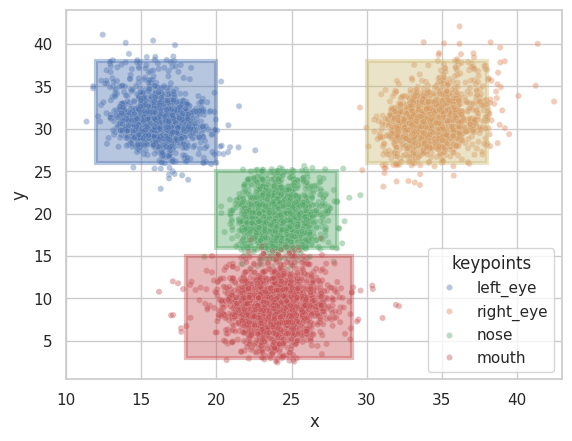

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical

# from mlxtend.plotting import plot_confusion_matrix

# download dataset from
# https://www.kaggle.com/code/ajayuser/emotion-detection-icml-face-data/

data = pd.read_csv('./fer2013_cleaning_2000v2_Sample_10.csv') # ..._Sample_01.csv to ..._Sample_10.csv
# Dropping the first 9 rows using slicing
data = data.iloc[9:]
data.head()

def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels und pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

    bar_label = emotions.values()

    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])

    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()

    plt.show()

def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()

    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()

    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()

    plt.show()


emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
			4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

train_image_array, train_image_label = prepare_data(data[data['Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data['Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data['Usage']=='PublicTest'])

image_array = np.vstack((train_image_array, val_image_array, test_image_array))
labels = np.hstack((train_image_label, val_image_label, test_image_label))

image_array = image_array.reshape((image_array.shape[0], 48, 48, 1))

# train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
# train_images = train_images.astype('float32')/255
# val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
# val_images = val_images.astype('float32')/255
# test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
# test_images = test_images.astype('float32')/255

# train_labels = to_categorical(train_image_label)
# val_labels = to_categorical(val_image_label)
# test_labels = to_categorical(test_image_label)

# plot_all_emotions()

## detect the facial landmarks
import cv2
import dlib

# Load the detector
detector = dlib.get_frontal_face_detector()

# Load the predictor
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# # read the image
# img = cv2.imread("face.jpg")

# # Convert image into grayscale
# gray = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)

import imutils

left_eye, right_eye, nose, mouth = [], [], [], []
valid_ind = []

for img_tmp in image_array:
    img_tmp = np.array(img_tmp, dtype=np.uint8)

    # Use detector to find landmarks
    faces = detector(img_tmp, 1)

    if len(faces) == 1:
        landmarks = predictor(image=img_tmp, box=faces[0])
        left_eye_tmp = [landmarks.part(38).x, landmarks.part(38).y] + .3*np.random.randn(2)
        right_eye_tmp = [landmarks.part(44).x, landmarks.part(44).y] + .3*np.random.randn(2)
        nose_tmp = [landmarks.part(30).x, landmarks.part(30).y] + .3*np.random.randn(2)
        mouth_tmp = [landmarks.part(66).x, landmarks.part(66).y] + .3*np.random.randn(2)
        if (landmarks.part(30).y > 22) \
            and (landmarks.part(30).y < 35) \
            and (landmarks.part(30).y - landmarks.part(40).y > 3) \
            and (landmarks.part(30).y - landmarks.part(46).y > 3) \
            and (landmarks.part(30).x - landmarks.part(39).x > 2) \
            and (landmarks.part(42).x - landmarks.part(30).x > 2) \
            and (landmarks.part(66).y - landmarks.part(30).y > 1) \
            and (abs(landmarks.part(27).x - 25) < 3):
        # if ( (left_eye_tmp[1]<=23) and (right_eye_tmp[1]<=23) and (nose_tmp[1]<=33) and (nose_tmp[1]>=23) and (mouth_tmp[1]>=33) ):
            valid_ind.append(1)
            # append data
            left_eye.append(left_eye_tmp)
            right_eye.append(right_eye_tmp)
            nose.append(nose_tmp)
            mouth.append(mouth_tmp)
        else:
            valid_ind.append(0)
    else:
        valid_ind.append(0)

valid_ind = np.array(valid_ind)
left_eye = np.array(left_eye, dtype=np.float32)
right_eye = np.array(right_eye, dtype=np.float32)
nose = np.array(nose, dtype=np.float32)
mouth = np.array(mouth, dtype=np.float32)

valid_image_array = image_array[np.where(valid_ind==1)[0]]
valid_label = labels[np.where(valid_ind==1)[0]]

n = len(left_eye)
df = {'x': [], 'y': [], 'keypoints': []}
df['x'].extend(left_eye[:,0])
df['y'].extend(48 - left_eye[:,1])
df['keypoints'].extend(['left_eye']*n)

df['x'].extend(right_eye[:,0])
df['y'].extend(48 - right_eye[:,1])
df['keypoints'].extend(['right_eye']*n)

df['x'].extend(nose[:,0])
df['y'].extend(48 - nose[:,1])
df['keypoints'].extend(['nose']*n)

df['x'].extend(mouth[:,0])
df['y'].extend(48 - mouth[:,1])
df['keypoints'].extend(['mouth']*n)

df = pd.DataFrame(df)

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

lm = sns.scatterplot(data=df, x="x", y="y",
            # col='keypoints', kind="scatter",
            hue="keypoints",
            s=20, alpha=.4)
lm.set(xlim=(10, 43))
rect_left_eye = patches.Rectangle((12, 26), 8, 12, linewidth=3,
                         edgecolor='b', facecolor='b',alpha=0.4)
rect_right_eye = patches.Rectangle((30, 26), 8, 12, linewidth=3,
                         edgecolor='y', facecolor='y',alpha=0.4)
rect_nose = patches.Rectangle((20, 16), 8, 9, linewidth=3,
                         edgecolor='g', facecolor='g',alpha=0.4)
rect_mouth = patches.Rectangle((18, 3), 11, 12, linewidth=3,
                         edgecolor='r', facecolor='r',alpha=0.4)
lm.add_patch(rect_left_eye)
lm.add_patch(rect_right_eye)
lm.add_patch(rect_nose)
lm.add_patch(rect_mouth)
plt.show()

# for i in range(7):
#     plt.axis('off')
#     ind_tmp = np.where(valid_label == i)[0][203]
#     plt.imshow(valid_image_array[ind_tmp], cmap='gray', vmin=0, vmax=255)
#     ax = plt.gca()
#     # plt.scatter(left_eye[ind_tmp,0], left_eye[ind_tmp,1], s=100, c='blue', marker='o')
#     # plt.scatter(right_eye[ind_tmp,0], right_eye[ind_tmp,1], s=100, c='yellow', marker='o')
#     # plt.scatter(nose[ind_tmp,0], nose[ind_tmp,1], s=100, c='green', marker='o')
#     # plt.scatter(mouth[ind_tmp,0], mouth[ind_tmp,1], s=100, c='red', marker='o')
#     rect_left_eye = patches.Rectangle((12, 14), 12, 8, linewidth=3,
#                          edgecolor='b', facecolor='b',alpha=0.5)
#     rect_right_eye = patches.Rectangle((30, 14), 12, 8, linewidth=3,
#                              edgecolor='y', facecolor='y',alpha=0.5)
#     rect_nose = patches.Rectangle((20, 25), 9, 8, linewidth=3,
#                              edgecolor='g', facecolor='g',alpha=0.5)
#     rect_mouth = patches.Rectangle((18, 35), 12, 11, linewidth=3,
#                              edgecolor='r', facecolor='r',alpha=0.5)
#     ax.add_patch(rect_left_eye)
#     ax.add_patch(rect_right_eye)
#     ax.add_patch(rect_nose)
#     ax.add_patch(rect_mouth)
#     plt.show()

# emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
#             4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


np.save('valid_image_array', valid_image_array)
np.save('valid_label', valid_label)
# np.save('left_eye', left_eye)
# np.save('right_eye', right_eye)
# np.save('nose', nose)
# np.save('mouth', mouth)


In [ ]:
valid_image_array.shape, valid_label.shape

((2000, 48, 48, 1), (2000,))

# main.py

In [ ]:
!pip install tensorflow==2.15.0

In [ ]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
# from BBoxTest import split_test
from sklearn.metrics import confusion_matrix
# from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras import models
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
# from tensorflow_addons.optimizers import SGDW, AdamW
from tensorflow.keras.optimizers import SGD, Adam

# dataset: https://www.kaggle.com/c
# /challenges-in-representation-learning-facial-expression-recognition-challenge/data

np.random.seed(0)
K.clear_session()

image_array = np.load('valid_image_array.npy')
label = np.load('valid_label.npy')
image_array /= 255.
image_array = image_array.astype('float32')

oh_label = to_categorical(label)

def VGG():
    model = Sequential()
    model.add(Conv2D(input_shape=(48,48,1),filters=64,kernel_size=(3,3),
                    padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(BatchNormalization(momentum=.9, epsilon=1e-5))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization(momentum=.9, epsilon=1e-5))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization(momentum=.9, epsilon=1e-5))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization(momentum=.9, epsilon=1e-5))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization(momentum=.9, epsilon=1e-5))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization(momentum=.9, epsilon=1e-5))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization(momentum=.9, epsilon=1e-5))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dropout(.2))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dropout(.2))

    model.add(Dense(units=7, activation="softmax"))

    return model


model_full, model_mask = VGG(), VGG()

model_full.compile(optimizer=SGD(learning_rate=.01, weight_decay=.0000, momentum=.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_mask.compile(optimizer=SGD(learning_rate=.01, weight_decay=.0000, momentum=.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


from keras.callbacks import EarlyStopping, ReduceLROnPlateau

scheduler = ReduceLROnPlateau(monitor='val_loss', mode='auto',
                factor=0.75, patience=5, verbose=True, min_lr=1e-8)

es = EarlyStopping(monitor='val_accuracy', mode='max',
          verbose=1, patience=50,
          restore_best_weights=True)

tic = time.perf_counter()

fit_params = {'callbacks': [scheduler, es],
              'epochs': 300,
              'batch_size': 128,
              'validation_split': .2,
              'verbose': 0}

split_params = {'split': 'one-split',
                'perturb': 0.03125,
                'num_perm': 100,
                'ratio_grid': [.2, .4, .6, .8],
                'perturb_grid': [.001, .005, .01, .05, .1],
                'min_inf': 100,
                'min_est': 1000,
                'ratio_method': 'fuse',
                'verbose': 1 }

# inf_feats = [
#           [np.arange(25,33), np.arange(20,29)], # Nose
#           [np.arange(34,45), np.arange(18,30)] # Mouth
#           [np.arange(10,26), np.arange(5,25)], # Left eye
#           [np.arange(10,26), np.arange(25,45)], # Right eye
#           [np.arange(10,26), np.arange(5,45)], # Two eye
#           [np.arange(0,5), np.arange(0,5)], # TL
#           [np.arange(4,44), np.arange(4,44)], # Face
#         ]

inf_feats = [
          [np.arange(10,26), np.arange(5,45)]
        ]

shiing = split_test(inf_feats=inf_feats,
              model=model_full, model_mask=model_mask,
              change='mask', eva_metric='cross-entropy') # eva_metric='cross-entropy' or 'zero-one'

p_value_tmp = shiing.testing(image_array, oh_label, cv_num=5, cp='hommel',
                            fit_params=fit_params,
                            split_params=split_params,
                            inf_ratio=0.2)


toc = time.perf_counter()

# shiing.visual(image_array[350:], oh_label[350:],
#               plt_params={'cmap': 'gray', 'alpha':1.})

print('testing time: %.3f' %(toc-tic))
print('P-values: %s' %p_value_tmp)



0-th inference; fix data splitting: n: 1600; m: 400

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.007499999832361937.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.005624999874271452.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.004218749818392098.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.003164062276482582.

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0023730467073619366.

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0017797850305214524.

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0013348387728910893.

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0010011291014961898.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0007508468697778881.

Epoch 52: ReduceLROnPlateau reducing learning rate to 0.000563135152333416.

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0004223513533361256.

Epoch 62: ReduceLROnPlateau reducing learning rate to 0.0003167635150020942.

Epoch 67: ReduceL